In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Training data

In [11]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/trainingDataAfterDataUnderstanding.csv")
data["Weekend"]=data["Weekend"].map(lambda x: 1 if x=="yes" else 0)

In [12]:
data.head()

,Temperature,Humidity,Light,CO2,Occupancy,Weekend
0,23.18,27.2720,426.0,721.25,1,0
1,23.15,27.2675,429.5,714.00,1,0
2,23.15,27.2450,426.0,713.50,1,0
3,23.15,27.2000,426.0,708.25,1,0
4,23.10,27.2000,426.0,704.50,1,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 6 columns):
Temperature    8143 non-null float64
Humidity       8143 non-null float64
Light          8143 non-null float64
CO2            8143 non-null float64
Occupancy      8143 non-null int64
Weekend        8143 non-null int64
dtypes: float64(4), int64(2)
memory usage: 381.8 KB


# Test data preparation

In [14]:
df = pd.read_csv('C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/datatestprepared.csv')
df["Weekend"]=df["Weekend"].map(lambda x: 1 if x=="yes" else 0)

test_features=df.drop(columns="Occupancy")

test_target=df["Occupancy"]

# Partition features and target

In [15]:
data_x=data.drop(columns="Occupancy")

data_y=data["Occupancy"]

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=100, stratify=data_y)

# Define selection algorithm and input data

In [17]:
def run_dim_reduction_algo(algo_instance, data_x, data_y=0):
    
    if str(algo_instance)[0:3] in ["RFE", "Sel"]:
        filtered_data=algo_instance.fit_transform(data_x,data_y)
        remaining_features=list(data_x.loc[:5, algo_instance.get_support()].columns)
    else:
        # we don't need the data_y if we are not using RFE or Univariate Feature Selection
        filtered_data=algo_instance.fit_transform(data_x)
        remaining_features=list(data_x.loc[:5, algo_instance.get_support()].columns)
        
    print("The remaining features are:")
    print(remaining_features)

# Variance threshold

In [18]:
from sklearn.feature_selection import VarianceThreshold
variance_x=VarianceThreshold(threshold=0.15)

In [19]:
run_dim_reduction_algo(variance_x, data_x)

The remaining features are:
['Temperature', 'Humidity', 'Light', 'CO2']


# Univariate Feature Selection

In [20]:
from sklearn.feature_selection import SelectKBest, chi2
sel = SelectKBest(chi2, k=2)

In [21]:
run_dim_reduction_algo(sel, data_x, data_y)

The remaining features are:
['Light', 'CO2']


# Recursive feature elimination

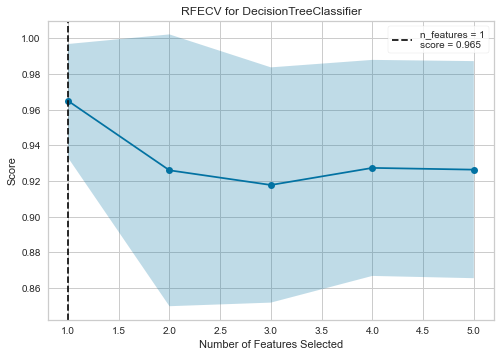

In [22]:
from yellowbrick.model_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

visualizer = RFECV(DecisionTreeClassifier(), cv=5)

visualizer.fit(data_x, data_y)        # Fit the data to the visualizer
visualizer.show()

In [23]:
from sklearn.feature_selection import RFE
rfe_algo=RFE(estimator=DecisionTreeClassifier(),n_features_to_select=1)

In [24]:
run_dim_reduction_algo(rfe_algo, data_x, data_y)

The remaining features are:
['Light']


# Principal Component Analysis

In [25]:
from sklearn.preprocessing import StandardScaler

data_x = pd.DataFrame((StandardScaler().fit_transform(data_x.select_dtypes(include=["int64", "float"]))), 
                      columns=(data_x.select_dtypes(include=["int64", "float"])).columns)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [27]:
# data_numeric=data_x.select_dtypes(include=["int", "float"])

filtered_data=pca.fit_transform(data_x)

principalDf = pd.DataFrame(data = filtered_data, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, data_y], axis = 1)

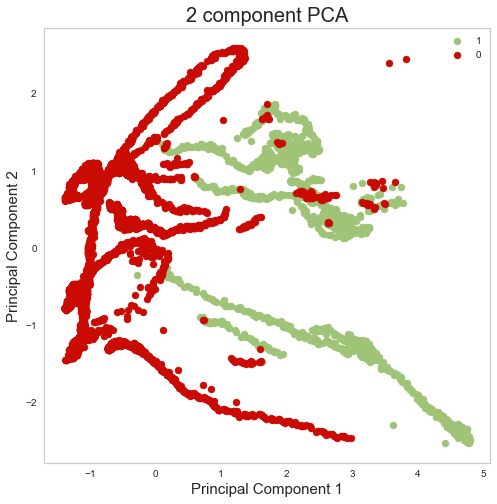

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1,0]
colors = ['g', 'r']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Occupancy'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

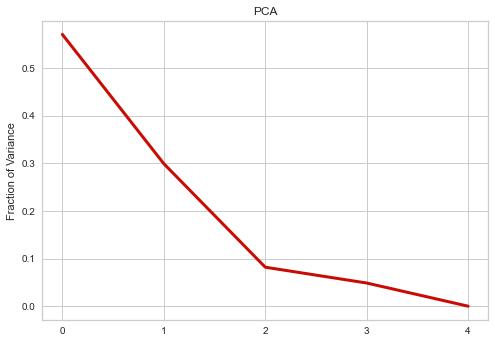

In [29]:
plt.plot(PCA(n_components=5).fit(data_x).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(5))
plt.show()

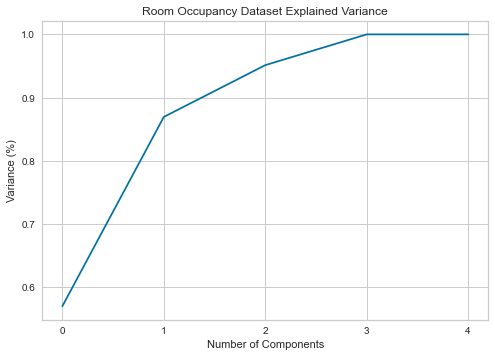

In [30]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(PCA(n_components=5).fit(data_x).explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.xticks(range(5))
plt.title('Room Occupancy Dataset Explained Variance')
plt.show()

# Decision tree with all features

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [32]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

Accuracy 0.9155190464685512
F1-score [0.94652052 0.79900364]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9396
           1       0.95      0.69      0.80      3021

    accuracy                           0.92     12417
   macro avg       0.93      0.84      0.87     12417
weighted avg       0.92      0.92      0.91     12417



# Decision tree with only 2 features

In [33]:
X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(test_features)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

Accuracy 0.9019892083434001
F1-score [0.93543424 0.79665831]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      9396
           1       0.80      0.79      0.80      3021

    accuracy                           0.90     12417
   macro avg       0.87      0.86      0.87     12417
weighted avg       0.90      0.90      0.90     12417



# Logistic regression with all features

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

Accuracy 0.989530482403157
F1-score [0.9930459  0.97882736]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9396
           1       0.96      0.99      0.98      3021

    accuracy                           0.99     12417
   macro avg       0.98      0.99      0.99     12417
weighted avg       0.99      0.99      0.99     12417



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Logistic regression with 2 features

In [36]:
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

Accuracy 0.9890472738986873
F1-score [0.99272027 0.97789337]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9396
           1       0.96      1.00      0.98      3021

    accuracy                           0.99     12417
   macro avg       0.98      0.99      0.99     12417
weighted avg       0.99      0.99      0.99     12417



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
